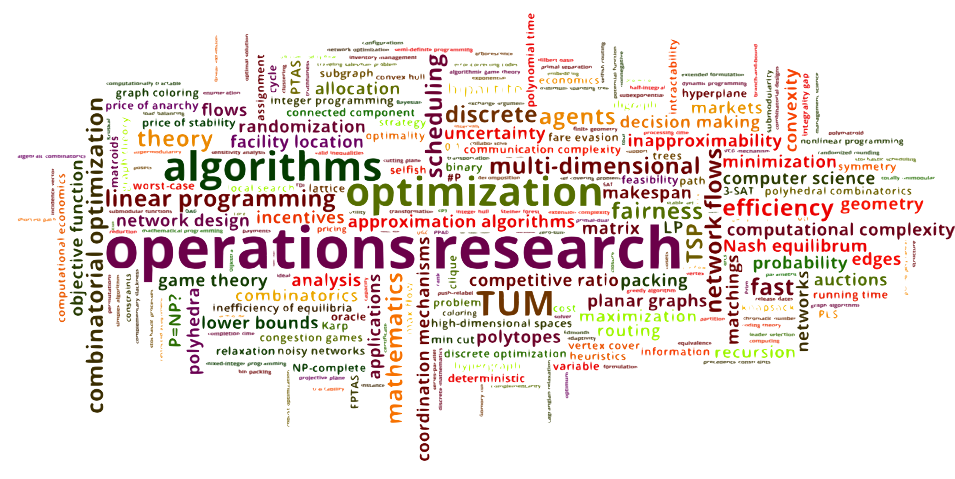


<b> Optimisation Case Study - Staff Planning </b> (Operations Research)

<b>Author:</b> Rama & Binoy George

<div class="alert alert-block alert-info">

# Assignment Summary:
    
## Problem Statement
An insurance company InsurePlus wants you to help them with finding the optimal number of staff that they need for their insurance application approval process for the calendar year 2021.
    
The objective is to optimise the total cost for the application approval process by distributing the right number of applications between the FTEs and the vendors while meeting the monthly demand for each state at the same time.  
    
</div>

# Data importing & prep-processing

In [1]:
# Importing Libraries 

import pandas as pd
import numpy as np
import math
from pyomo.environ import *

In [2]:
from __future__ import division
from pyomo.opt import SolverFactory

In [3]:
# Reading the data from Excel workbook

InputFile='Staffing+Data.xlsx'
Demand = pd.read_excel(InputFile, sheet_name='DemandData')
Staff = pd.read_excel(InputFile, sheet_name='StaffAvailability')
Cost = pd.read_excel(InputFile, sheet_name = 'Cost')
MgAppServedPerMonth=40


In [4]:
# Check for data loading

Demand.head()

,State,Month,Demand
0,A,Jan,5240
1,A,Feb,4878
2,A,Mar,5942
3,A,Apr,2297
4,A,May,1992


In [5]:
Staff.head()

,State,Month,LB,UB,StaffAvPer
0,A,Jan,0.70,0.90,0.81
1,A,Feb,0.65,0.85,0.76
2,A,Mar,0.70,0.80,0.75
3,A,Apr,0.75,0.85,0.80
4,A,May,0.70,0.85,0.78


In [6]:
Cost.head()

,State,Month,AnnualSalary,MonthlySalary,UnitOutSourceCost,UnitOutCost_v2
0,A,Jan,60000,5000.0,180,155
1,A,Feb,60000,5000.0,180,155
2,A,Mar,60000,5000.0,180,155
3,A,Apr,60000,5000.0,180,155
4,A,May,60000,5000.0,180,155


In [7]:
#Combining the data to a single dataframe

data=pd.merge(Demand,Staff ,on=['State','Month'])
data
data=pd.merge(data,Cost,on = ['State','Month'])
data.head()


,State,Month,Demand,LB,UB,StaffAvPer,AnnualSalary,MonthlySalary,UnitOutSourceCost,UnitOutCost_v2
0,A,Jan,5240,0.70,0.90,0.81,60000,5000.0,180,155
1,A,Feb,4878,0.65,0.85,0.76,60000,5000.0,180,155
2,A,Mar,5942,0.70,0.80,0.75,60000,5000.0,180,155
3,A,Apr,2297,0.75,0.85,0.80,60000,5000.0,180,155
4,A,May,1992,0.70,0.85,0.78,60000,5000.0,180,155


## Data pre-processing 

In [8]:
# Create the required Python data structures for indexes and parameters


# Extracting States into a list
states=data['State'].unique()
print('The states present are:',states)

# Extracting Months into a list
months=data['Month'].unique()
print("The Months present are: ",months)


The states present are: ['A' 'B' 'C']
The Months present are:  ['Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' 'Nov' 'Dec']


In [9]:
# Extracting Staff Average availability for each state for each month 
staffav=data.set_index(['State','Month'])['StaffAvPer'].to_dict()
print("The average staff availability by state by month:\n",staffav)

# No:of applications processed when staff is 100% available
servrate = 40

# Outsource restrictions for state A
outrestA = 0.3

# Outsource restrictions for state B
outrestB = 0.4

The average staff availability by state by month:
 {('A', 'Jan'): 0.81, ('A', 'Feb'): 0.76, ('A', 'Mar'): 0.75, ('A', 'Apr'): 0.8, ('A', 'May'): 0.78, ('A', 'Jun'): 0.73, ('A', 'Jul'): 0.68, ('A', 'Aug'): 0.76, ('A', 'Sep'): 0.81, ('A', 'Oct'): 0.73, ('A', 'Nov'): 0.68, ('A', 'Dec'): 0.65, ('B', 'Jan'): 0.81, ('B', 'Feb'): 0.76, ('B', 'Mar'): 0.75, ('B', 'Apr'): 0.8, ('B', 'May'): 0.78, ('B', 'Jun'): 0.73, ('B', 'Jul'): 0.68, ('B', 'Aug'): 0.76, ('B', 'Sep'): 0.81, ('B', 'Oct'): 0.73, ('B', 'Nov'): 0.68, ('B', 'Dec'): 0.65, ('C', 'Jan'): 0.81, ('C', 'Feb'): 0.76, ('C', 'Mar'): 0.75, ('C', 'Apr'): 0.8, ('C', 'May'): 0.78, ('C', 'Jun'): 0.73, ('C', 'Jul'): 0.68, ('C', 'Aug'): 0.76, ('C', 'Sep'): 0.81, ('C', 'Oct'): 0.73, ('C', 'Nov'): 0.68, ('C', 'Dec'): 0.65}


In [10]:
# Demand for the insurance for each state,month
demand=data.set_index(['State','Month'])['Demand'].to_dict()
print('Demand for Insurance application per state by month :\n',demand)

#Extracting Lower Bound Availability for each state,Month
lb=data.set_index(['State','Month'])['LB'].to_dict()
print('Lower Bound per state by month :\n',lb)

#Extracting Upper Bound Availability for each state,Month
ub=data.set_index(['State','Month'])['UB'].to_dict()
print('Upper Bound per state by month :\n',ub)


Demand for Insurance application per state by month :
 {('A', 'Jan'): 5240, ('A', 'Feb'): 4878, ('A', 'Mar'): 5942, ('A', 'Apr'): 2297, ('A', 'May'): 1992, ('A', 'Jun'): 2275, ('A', 'Jul'): 5334, ('A', 'Aug'): 3371, ('A', 'Sep'): 3759, ('A', 'Oct'): 3529, ('A', 'Nov'): 4284, ('A', 'Dec'): 5183, ('B', 'Jan'): 4927, ('B', 'Feb'): 2628, ('B', 'Mar'): 2974, ('B', 'Apr'): 2338, ('B', 'May'): 4020, ('B', 'Jun'): 3147, ('B', 'Jul'): 4271, ('B', 'Aug'): 2620, ('B', 'Sep'): 4517, ('B', 'Oct'): 4155, ('B', 'Nov'): 3137, ('B', 'Dec'): 4227, ('C', 'Jan'): 1162, ('C', 'Feb'): 1967, ('C', 'Mar'): 1898, ('C', 'Apr'): 2261, ('C', 'May'): 2030, ('C', 'Jun'): 1642, ('C', 'Jul'): 2489, ('C', 'Aug'): 2496, ('C', 'Sep'): 922, ('C', 'Oct'): 2421, ('C', 'Nov'): 963, ('C', 'Dec'): 1998}
Lower Bound per state by month :
 {('A', 'Jan'): 0.7, ('A', 'Feb'): 0.65, ('A', 'Mar'): 0.7, ('A', 'Apr'): 0.75, ('A', 'May'): 0.7, ('A', 'Jun'): 0.65, ('A', 'Jul'): 0.6, ('A', 'Aug'): 0.65, ('A', 'Sep'): 0.7, ('A', 'Oct'): 0.

In [11]:
# Cost/salary of Staff for each state for each month
salary=data.set_index(['State','Month'])['MonthlySalary'].to_dict()
print("Monthly Salary of staff per state by month:\n",salary)

# Cost of resource provided by vendor1
costvendor1=data.set_index(['State','Month'])['UnitOutSourceCost'].to_dict()
print("Outsource cost for vendor 1 per state by month:\n",costvendor1)

# Cost of resource provided by vendor2
costvendor2=data.set_index(['State','Month'])['UnitOutCost_v2'].to_dict()
print("Outsource cost for vendor 2 per state by month:\n",costvendor2)

Monthly Salary of staff per state by month:
 {('A', 'Jan'): 5000.0, ('A', 'Feb'): 5000.0, ('A', 'Mar'): 5000.0, ('A', 'Apr'): 5000.0, ('A', 'May'): 5000.0, ('A', 'Jun'): 5000.0, ('A', 'Jul'): 5000.0, ('A', 'Aug'): 5000.0, ('A', 'Sep'): 5000.0, ('A', 'Oct'): 5000.0, ('A', 'Nov'): 5000.0, ('A', 'Dec'): 5000.0, ('B', 'Jan'): 4583.333333333333, ('B', 'Feb'): 4583.333333333333, ('B', 'Mar'): 4583.333333333333, ('B', 'Apr'): 4583.333333333333, ('B', 'May'): 4583.333333333333, ('B', 'Jun'): 4583.333333333333, ('B', 'Jul'): 4583.333333333333, ('B', 'Aug'): 4583.333333333333, ('B', 'Sep'): 4583.333333333333, ('B', 'Oct'): 4583.333333333333, ('B', 'Nov'): 4583.333333333333, ('B', 'Dec'): 4583.333333333333, ('C', 'Jan'): 4416.666666666667, ('C', 'Feb'): 4416.666666666667, ('C', 'Mar'): 4416.666666666667, ('C', 'Apr'): 4416.666666666667, ('C', 'May'): 4416.666666666667, ('C', 'Jun'): 4416.666666666667, ('C', 'Jul'): 4416.666666666667, ('C', 'Aug'): 4416.666666666667, ('C', 'Sep'): 4416.66666666666

# Question 1

The company wants to know the optimised staffing recommendations for the business case described. 
Write the mathematical model for the deterministic optimisation problem. Define and explain your decision variables, objective function and the constraint. (Hint: Use months of the year as the model timeline).



<div class="alert alert-block alert-warning">

## Decision Variable
- x[s,m] -> FTE ( Number of applications processed for each state for each month)
- y[s,m] -> Number of outsourced application for each state for each month

## Objective Function:

- We need to minimize the cost of proecessing insurance applications

Minimise (∑1_𝑖∑1_𝑗〖𝑋(s,m)∗〗 𝐹𝑇𝐸𝑆𝑎𝑙𝑎𝑟𝑦(s, m)+  ∑1_𝑖∑1_𝑗〖𝑌(s, m)∗〗 𝑈𝑛𝑖𝑡𝐶𝑜𝑠𝑡(s, m) ) for all s in States for all m in Months

 
## Constraints
- <b>Demand constraints: Demand of insurance for each state for each month</b>
    
    For each state-month:
    x[s,m]* Service rate* StaffAvPer[s,m]  + y[s,m] == demand

- <b> Staff Availability Limits/ Best and worst case scenario </b>
            
     StaffAvPer[s,m] > lb[s,m] for s in States and for m in Months ( average availability > Lower Bound )
         
     StaffAvPer[s,m] < ub[s,m] for s in States and for m in Months ( average availability < Upper Bound )
     
- <b> Vendor Outsource Limits for State A and B </b>
         
   y[A,m] < (outrestA[A,m]*outsourcevendor1[A,m]) for S = A and for m in Months
         
   y[B,m] < (outrestB[B.m]*outsourcevendor2[B,m] for S = B and for m in Months
    
</div>

**Note:** You can write the mathematical formulation directly in your report.

# Question 2

Code the problem is Python and use any optimization package to solve it. Add comments to your code to explain each step. 

## Expected output:

Create a data frame containing the number of outsourced applications  and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. 

In [12]:
# Creating a model instance

model = ConcreteModel()

In [13]:
# Define Pyomo sets and Parameters

model.i=Set(initialize=states)
model.j=Set(initialize=months)

# Defining parameter Demand
model.d = Param(model.i, model.j, initialize = demand)

# defining parameter Staff Average availablility
model.staffav = Param(model.i, model.j, initialize = staffav)

# Defining parameter Staff Salary
model.staffslry = Param(model.i, model.j, initialize = salary)

# Defining parameter cost for vendor 1
model.costvendor1 = Param(model.i, model.j, initialize = costvendor1)

# Defining Parameter for Outsourcing for state A
def Reg_A(model,i,j):
    return (outrestA*model.d[i,j])

model.Reg_A = Param(model.i, model.j, initialize = Reg_A)

# Defining Parameter for Outsourcing for State B
def Reg_B(model,i,j):
    return (outrestB*model.d[i,j])

model.Reg_B = Param(model.i, model.j, initialize = Reg_B)


In [14]:
# Decision variables

model.x=Var(model.i, model.j ,within=NonNegativeReals)
model.y=Var(model.i, model.j,within=NonNegativeIntegers)

In [15]:
# Constraints


StmnthInd = list(model.d.keys())
print("The index for state month combination:\n",StmnthInd)
# Demand Constraint for Insurance Applications
# Insurance applications processed should be equal to the total count/demand of applications for each state for each month
def demand_insurance(model,i,j):
    return (((model.x[i,j]*servrate*model.staffav[i,j]) + model.y[i,j]) == model.d[i,j])

model.demand = Constraint(StmnthInd, rule = demand_insurance)

The index for state month combination:
 [('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')]


In [16]:
# Constraint for State A
# Outsource applications should not exceed 30% of Demand for that respective Month
def outsourc_state_A(model,i,j):
    return (model.y[i,j] <= model.Reg_A[i,j])

model.outsourc_state_A = Constraint("A", model.j, rule = outsourc_state_A )

# Constraint for State B
# Outsource applications should not exceed 40% of Demand for that respective Month
def outsourc_state_B(model,i,j):
    return (model.y[i,j] <= model.Reg_B[i,j])

model.outsourc_state_B = Constraint("B", model.j, rule = outsourc_state_B)

In [17]:
# Objective function

def obj_func(model):
    return (sum((model.x[i]*model.staffslry[i])+(model.y[i]*model.costvendor1[i]) for i in StmnthInd))
            
model.totalCost = Objective(rule = obj_func, sense = minimize) 

In [18]:
# Invoking the solver

result = SolverFactory('glpk').solve(model)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 17962336.4487699
  Upper bound: 17962336.4487699
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.013996362686157227
# ----------------------------------------------------------
#   Solution Information
# -----------

In [19]:
# Print the value of the objective function

print("Total Cost M$:", round((model.totalCost()/1000000),2))


Total Cost M$: 17.96


<div class="alert alert-block alert-warning">
    
**Checkpoint 1:** Seems like the company has to spend around 17.9 m$ in total for the application approval process.

</div>

In [20]:
# Creating dataframe for the results

FTE=[round(value(model.x[i]),2)for i in StmnthInd]
Outsourced = [round(value(model.y[i]),2)for i in StmnthInd]

temp = {"StateMonth": StmnthInd,"FTE":FTE, "Outsourcmodel": Outsourced, "StaffAvailability":data["StaffAvPer"]}
result_df=pd.DataFrame(data=temp)


In [21]:
result_df['Demand'] = Demand['Demand']
result_df['FTE_App_Served'] = round(result_df['FTE']*40*result_df['StaffAvailability'],0)
result_df['App_Outsourced'] = round(result_df['Demand'] - result_df['FTE_App_Served'],0)

result_df.head()

,StateMonth,FTE,Outsourcmodel,StaffAvailability,Demand,FTE_App_Served,App_Outsourced
0,"(A, Jan)",161.73,0.0,0.81,5240,5240.0,0.0
1,"(A, Feb)",160.46,0.0,0.76,4878,4878.0,0.0
2,"(A, Mar)",198.07,0.0,0.75,5942,5942.0,0.0
3,"(A, Apr)",71.78,0.0,0.80,2297,2297.0,0.0
4,"(A, May)",63.85,0.0,0.78,1992,1992.0,0.0


In [22]:
# Writing the results in to an Excel sheet

with pd.ExcelWriter('result01_DF.xlsx') as writer:
    result_df.to_excel(writer)


# Question 3 

## Expected Scenarios

The company wants to get a solution for the scenario, where no more than 10% of the total applications for every month in each state is handled by the external resources, for quality assurance reasons

- **`Q 3.1-`** What is the additional average cost per application of keeping the 10% limit on outsourcing? 
Note: Compare with the cost in question 2

- **`Q 3.2-`** If the company increases the outsourcing costs by 20% to reflect the cost of quality assurance, what would you recommend the optimal percent of outsourcing should be?



## Expected output: 
`Subtask 3.1-` Create a data frame containing the number of outsourced applications and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. Also, print the additional average cost per application.

`Subtask 3.2-` Create a data frame containing the number of outsourced applications and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. Also, print the additional average cost per application. Also, print the overall average optimal per cent of outsourcing.

### Question 3.1: Additional cost per application of keeping the 10% limit on outsourcing

In [23]:
# Creating a model instance

model2 = ConcreteModel()

In [24]:
# Define Pyomo sets and Parameters


model2.i = Set(initialize = states)
model2.j = Set(initialize = months)

# Defining parameter Demand
model2.d = Param(model2.i, model2.j, initialize = demand)

# Defining parameter Staff Availability
model2.staffav = Param(model2.i, model2.j, initialize = staffav)

# Defining parameter Staff salary
model2.staffslry = Param(model2.i, model2.j, initialize = salary)

# Defining Parameter for Cost of Vendor 1
model2.costvendor1 = Param(model2.i, model2.j, initialize = costvendor1)

# Defining Parameter for Keeping outsourcing limit to <= 10% of applications for each state for each month
def Reg_outsource(model2,i,j):
    return (0.10*model2.d[i,j])
model2.Reg_outsource = Param(model2.i, model2.j, initialize = Reg_outsource)

In [25]:
# Decision variables


model2.x = Var(model2.i, model2.j, domain = NonNegativeReals)
model2.y = Var(model2.i, model2.j, domain = NonNegativeIntegers)

In [26]:
# Constraints

# Constraint for Demand of insurance Applications
Indstmnth=list(model2.d.keys())

# Insurance applications processed should be equal to demand per state per month
def demand_insurance(model2,i,j):
    return (((model2.x[i,j]*40*model2.staffav[i,j])+model2.y[i,j]) == model2.d[i,j])

model2.demand =  Constraint(Indstmnth, rule = demand_insurance)


In [27]:
# Constraint to Outsource applications should not exceed 20% of total demand for each state for each month
def outsource_limit_states(model2,i,j):
    return (model2.y[i,j] <= model2.Reg_outsource[i,j])

model2.outsource_limit = Constraint(Indstmnth, rule = outsource_limit_states)

In [28]:
# Objective function
def obj_func(model2):
    return (sum((model2.x[i]*model2.staffslry[i])+(model2.y[i]*model2.costvendor1[i]) for i in Indstmnth))

model2.totalCost = Objective(rule = obj_func, sense = minimize)


In [29]:
# Invoking the solver
result = SolverFactory("glpk").solve(model2)
result.write()


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 18100979.3212198
  Upper bound: 18100979.3212198
  Number of objectives: 1
  Number of constraints: 73
  Number of variables: 73
  Number of nonzeros: 109
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.01296091079711914
# ----------------------------------------------------------
#   Solution Information
# -----------

In [30]:
# Print the value of the objective function

print("Total Cost M$:", round((model2.totalCost()/1000000),2))

Total Cost M$: 18.1


<div class="alert alert-block alert-warning">
    
**Checkpoint 2:** The company has to spend around 18.1 m$ in total for the application approval process if there is 10% limit on the outsourcing.

</div>

In [31]:
# Creating dataframe for the results
FTE = [round(value(model2.x[i]),2) for i in Indstmnth]
print(FTE)
outsourced = [round(value(model2.y[i]),2) for i in Indstmnth]
print(outsourced)

temp = {"StateMonth":Indstmnth, "FTE": FTE, "Outsourced": outsourced,"StaffAvail": list(staffav.values())}
result2_df=pd.DataFrame(data=temp)


[161.73, 160.46, 198.07, 71.78, 63.85, 77.91, 176.51, 110.89, 116.02, 120.86, 141.76, 179.42, 152.07, 77.83, 89.23, 73.06, 128.85, 97.02, 141.32, 77.57, 139.41, 128.08, 103.82, 146.35, 35.86, 64.7, 63.27, 70.66, 65.06, 56.23, 82.39, 82.11, 28.46, 82.91, 31.88, 69.19]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 533.0, 0.0, 0.0, 0.0, 428.0, 518.0, 0.0, 262.0, 297.0, 0.0, 0.0, 314.0, 427.0, 262.0, 0.0, 415.0, 313.0, 422.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 248.0, 0.0, 0.0, 0.0, 96.0, 199.0]


In [32]:
result2_df['Demand'] = Demand['Demand']
result2_df['FTE_App_Served'] = round(result2_df['FTE']*40*result2_df['StaffAvail'],0)
result2_df['App_Outsourced'] = round(result2_df['Demand'] - result2_df['FTE_App_Served'],0)

result2_df.head()

,StateMonth,FTE,Outsourced,StaffAvail,Demand,FTE_App_Served,App_Outsourced
0,"(A, Jan)",161.73,0.0,0.81,5240,5240.0,0.0
1,"(A, Feb)",160.46,0.0,0.76,4878,4878.0,0.0
2,"(A, Mar)",198.07,0.0,0.75,5942,5942.0,0.0
3,"(A, Apr)",71.78,0.0,0.80,2297,2297.0,0.0
4,"(A, May)",63.85,0.0,0.78,1992,1992.0,0.0


In [33]:
# Additional cost per application

#The additional average cost per application of keeping the 10% limit on outsourcing:

totalApplctns = sum(model2.d[i] for i in Indstmnth)
totalApplctns
costperapplctn_1 = model.totalCost()/totalApplctns
costperapplctn_2 = model2.totalCost()/totalApplctns
print("\nCost per Application with distribution to FTE and Outsourced limit of 30 % (State A) and 40 % (State B) - ",round(costperapplctn_1,2))
print("\nCost per Application with distribution to FTE and Outsourced limit of 10 % to all States - ",round(costperapplctn_2,2))
print("\nAdditional Cost per application is - ",round(costperapplctn_2 - costperapplctn_1,2))




Cost per Application with distribution to FTE and Outsourced limit of 30 % (State A) and 40 % (State B) -  158.55

Cost per Application with distribution to FTE and Outsourced limit of 10 % to all States -  159.77

Additional Cost per application is -  1.22


<div class="alert alert-block alert-warning">
    
<b> Additional Cost per application is $1.22 </b>

</div>

### Question 3.2:  Increase in the outsourcing costs by 20% 

In [34]:
# Creating a model instance
model3 = ConcreteModel()

In [35]:
# Define Pyomo sets and Parameters

model3.i = Set(initialize = states)
model3.j = Set(initialize = months)

# Defining parameter Demand
model3.d = Param(model3.i, model3.j, initialize = demand)

# Defining Staff Availability
model3.staffav = Param(model3.i, model3.j, initialize = staffav)

# Defining Staff Salary
model3.staffslry = Param(model3.i, model3.j, initialize = salary)

# Defining Cost of Vendor1
model3.costvendor1 = Param(model3.i, model3.j, initialize = costvendor1)

# Defining Parameter of outsourcing for state
# Defining Parameter for Keeping outsourcing limit to <= 10% of applications for each state for each month
def Reg_outsource(model3,i,j):
    return (0.10*model3.d[i,j])
model3.Reg_outsource = Param(model3.i, model3.j, initialize = Reg_outsource)


In [36]:
# Decision variables

model3.x = Var(model3.i, model3.j, domain = NonNegativeReals)
model3.y = Var(model3.i, model3.j, domain = NonNegativeIntegers)

In [37]:
# Constraints

# Constraint for Demand of insurance Applications
Indstmnth=list(model3.d.keys())

# Insurance applications processed should be equal to demand per state per month
def demand_insurance(model3,i,j):
    return (((model3.x[i,j]*40*model3.staffav[i,j])+model3.y[i,j]) == model3.d[i,j])

model3.demand =  Constraint(Indstmnth, rule = demand_insurance)

In [38]:
# Constraint to Outsource applications should not exceed 20% of total demand for each state for each month
def outsource_limit_states(model3,i,j):
    return (model3.y[i,j] <= model3.Reg_outsource[i,j])

model3.outsource_limit = Constraint(Indstmnth, rule = outsource_limit_states)

In [39]:
# Objective function

def obj_func(model3):
    return (sum((model3.x[i]*model3.staffslry[i])+(model3.y[i]*(model3.costvendor1[i]+(0.2*model3.costvendor1[i]))) for i in Indstmnth))

model3.totalCost = Objective(rule = obj_func, sense = minimize)


In [40]:
# Invoking the solver

result3 = SolverFactory("glpk").solve(model3)
result3.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 18144899.6638542
  Upper bound: 18144899.6638542
  Number of objectives: 1
  Number of constraints: 73
  Number of variables: 73
  Number of nonzeros: 109
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.013953685760498047
# ----------------------------------------------------------
#   Solution Information
# ----------

In [41]:
# Creating dataframe for the results


FTE = [round(value(model3.x[i]),2) for i in Indstmnth]
print(FTE)
outsourced = [round(value(model3.y[i]),2) for i in Indstmnth]
print(outsourced)

temp = {"StateMonth":Indstmnth, "FTE": FTE, "Outsourced": outsourced,"StaffAvail": list(staffav.values())}
result3_df=pd.DataFrame(data=temp)


[161.73, 160.46, 198.07, 71.78, 63.85, 77.91, 196.1, 110.89, 116.02, 120.86, 157.5, 199.35, 152.07, 86.45, 99.13, 73.06, 128.85, 107.77, 157.02, 86.18, 139.41, 142.29, 115.33, 162.58, 35.86, 64.7, 63.27, 70.66, 65.06, 56.23, 91.51, 82.11, 28.46, 82.91, 35.4, 76.85]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [42]:
result3_df['Demand'] = Demand['Demand']
result3_df['FTE_App_Served'] = round(result3_df['FTE']*40*result3_df['StaffAvail'],0)
result3_df['App_Outsourced'] = round(result3_df['Demand'] - result3_df['FTE_App_Served'],0)

result3_df.head()

,StateMonth,FTE,Outsourced,StaffAvail,Demand,FTE_App_Served,App_Outsourced
0,"(A, Jan)",161.73,0.0,0.81,5240,5240.0,0.0
1,"(A, Feb)",160.46,0.0,0.76,4878,4878.0,0.0
2,"(A, Mar)",198.07,0.0,0.75,5942,5942.0,0.0
3,"(A, Apr)",71.78,0.0,0.80,2297,2297.0,0.0
4,"(A, May)",63.85,0.0,0.78,1992,1992.0,0.0


In [43]:
# Print the value of the objective function

print("Total Cost of processing the application in M$:", round((model3.totalCost()/1000000),2))

Total Cost of processing the application in M$: 18.14


<div class="alert alert-block alert-warning">

**Checkpoint 3:** On increasing the outsourcing cost by 20%, the company has to spend around 18.14 m$, which is slightly more than the previous case .

</div>

In [44]:
# Average optimal percentage of outsourcing 

# % of outsourced application can be found by the below formula:
# outsource / demand *100

# #Converting a list into a dataframe
outsourced_df = pd.DataFrame(outsourced,columns=['outsourced'])
outsourced_df.head()

,outsourced
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [45]:
data_n = data.copy()
data_n['outsourced']=outsourced_df['outsourced']

data_n['outsourced %'] = (data_n['outsourced']/data_n['Demand']) * 100

In [46]:
data_n[["State","Month","Demand","outsourced","outsourced %"]]

,State,Month,Demand,outsourced,outsourced %
0,A,Jan,5240,0.0,0.0
1,A,Feb,4878,0.0,0.0
2,A,Mar,5942,0.0,0.0
3,A,Apr,2297,0.0,0.0
4,A,May,1992,0.0,0.0
5,A,Jun,2275,0.0,0.0
6,A,Jul,5334,0.0,0.0
7,A,Aug,3371,0.0,0.0
8,A,Sep,3759,0.0,0.0
9,A,Oct,3529,0.0,0.0


In [47]:
# Average optimal percentage of outsourcing 

data_n['outsourced %'].mean()

0.0

# Question 4

- Worst-case and best-case analysis based on the staffs' availability.

Assuming that the distribution is the same across all the states,

- 4.1 Worst case analysis 

    - 4.1.1 What is the optimal number of staff members for the worst and best cases? 

    - 4.1.2 What is the percentage of outsourcing for the worst and best cases? 

    - 4.1.3 What is the average cost per application for the worst and best cases?


- 4.2 Best case analysis 

    - 4.2.1 What is the optimal number of staff members for the worst and best cases? 

    - 4.2.2 What is the percentage of outsourcing for the worst and best cases? 

    - 4.2.3 What is the average cost per application for the worst and best cases?


## Expected output:

For each of the subtasks (4.1 and 4.2) create a data frame containing the number of outsourced applications and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. Also, print the overall average percentage of outsourced applications and the overall average cost per application. 

## Question 4.1: Worst Case Analysis 

### 4.1.1 Optimal number of staff members

In [48]:
# Creating a model instance

model4 = ConcreteModel()

In [49]:
# Define Pyomo sets and Parameters

model4.i = Set(initialize = states)
model4.j = Set(initialize = months)

# Defining parameter Demand
model4.d = Param(model4.i, model4.j, initialize = demand)

# Defining Staff Availability with Lower Bound
model4.staffav = Param(model4.i, model4.j, initialize = lb)

# Defining Staff Salary
model4.staffslry = Param(model4.i, model4.j, initialize = salary)

# Defining Cost of Vendor1
model4.costvendor1 = Param(model4.i, model4.j, initialize = costvendor1)

# Defining Parameter of outsourcing for state
## Defining Parameter for Outsourcing for state A
def Reg_A(model4,i,j):
    return (outrestA*model4.d[i,j])

model4.Reg_A = Param(model4.i, model4.j, initialize = Reg_A)

# Defining Parameter for Outsourcing for State B
def Reg_B(model4,i,j):
    return (outrestB*model4.d[i,j])

model4.Reg_B = Param(model4.i, model4.j, initialize = Reg_B)

In [50]:
# Decision variables

model4.x = Var(model4.i, model4.j, domain = NonNegativeReals)
model4.y = Var(model4.i, model4.j, domain = NonNegativeIntegers)

In [51]:
# Constraints

# Constraint for Demand of insurance Applications
Indstmnth=list(model4.d.keys())

# Insurance applications processed should be equal to demand per state per month
def demand_insurance(model4,i,j):
    return (((model4.x[i,j]*40*model4.staffav[i,j])+model4.y[i,j]) == model4.d[i,j])

model4.demand =  Constraint(Indstmnth, rule = demand_insurance)

In [52]:
# Constraint for State A
# Outsource applications should not exceed 30% of Demand for that respective Month
def outsourc_state_A(model4,i,j):
    return (model4.y[i,j] <= model4.Reg_A[i,j])

model4.outsourc_state_A = Constraint("A", model4.j, rule = outsourc_state_A )

# Constraint for State B
# Outsource applications should not exceed 40% of Demand for that respective Month
def outsourc_state_B(model4,i,j):
    return (model4.y[i,j] <= model4.Reg_B[i,j])

model4.outsourc_state_B = Constraint("B", model4.j, rule = outsourc_state_B)

In [53]:
# Objective function

def obj_func(model4):
    return (sum((model4.x[i]*model4.staffslry[i])+(model4.y[i]*model4.costvendor1[i]) for i in Indstmnth))

model4.totalCost = Objective(rule = obj_func, sense = minimize)

In [54]:
# Invoking the solver

result4 = SolverFactory("glpk").solve(model4)
result4.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 19599482.5167888
  Upper bound: 19599482.5167888
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.012965679168701172
# ----------------------------------------------------------
#   Solution Information
# -----------

In [55]:
# Print the value of the objective function

print("Total Cost of processing the application in M$:", round((model4.totalCost()/1000000),2))

Total Cost of processing the application in M$: 19.6


<div class="alert alert-block alert-warning">

**Checkpoint 4:** The company has to spend around <b>19.6 m$ </b> in total for the application approval process if the staffs are working with the minimum availability.

</div>

In [56]:
# Creating dataframe for the results

FTE = [round(value(model4.x[i]),2) for i in Indstmnth]
print(FTE)
outsourced = [round(value(model4.y[i]),2) for i in Indstmnth]
print(outsourced)

temp = {"StateMonth":Indstmnth, "FTE": FTE, "Outsourced": outsourced,"StaffAvail": list(lb.values())}
result4_df=pd.DataFrame(data=temp)


[187.14, 131.35, 212.21, 76.57, 71.14, 61.27, 155.58, 90.77, 134.25, 95.04, 124.96, 151.21, 105.61, 60.65, 63.75, 46.77, 86.14, 72.65, 106.79, 60.46, 96.82, 95.88, 78.46, 105.71, 41.5, 0.0, 67.79, 75.37, 72.5, 0.0, 0.0, 0.0, 32.93, 0.0, 0.0, 0.0]
[0.0, 1463.0, 0.0, 0.0, 0.0, 682.0, 1600.0, 1011.0, 0.0, 1058.0, 1285.0, 1554.0, 1970.0, 1051.0, 1189.0, 935.0, 1608.0, 1258.0, 1708.0, 1048.0, 1806.0, 1662.0, 1254.0, 1690.0, 0.0, 1967.0, 0.0, 0.0, 0.0, 1642.0, 2489.0, 2496.0, 0.0, 2421.0, 963.0, 1998.0]


In [57]:
result4_df['Demand'] = Demand['Demand']
result4_df['FTE_App_Served'] = round(result4_df['FTE']*40*result4_df['StaffAvail'],0)
result4_df['App_Outsourced'] = round(result4_df['Demand'] - result4_df['FTE_App_Served'],0)

result4_df.head()

,StateMonth,FTE,Outsourced,StaffAvail,Demand,FTE_App_Served,App_Outsourced
0,"(A, Jan)",187.14,0.0,0.70,5240,5240.0,0.0
1,"(A, Feb)",131.35,1463.0,0.65,4878,3415.0,1463.0
2,"(A, Mar)",212.21,0.0,0.70,5942,5942.0,0.0
3,"(A, Apr)",76.57,0.0,0.75,2297,2297.0,0.0
4,"(A, May)",71.14,0.0,0.70,1992,1992.0,0.0


### 4.1.2 Percentage of outsourced applications 

In [58]:
# write your code here

# % of outsourced application can be found by the below formula:
# outsource / demand *100

# #Converting a list into a dataframe
outsourced_df_WC = pd.DataFrame(outsourced,columns=['outsourced_WC'])
outsourced_df_WC.head()

,outsourced_WC
0,0.0
1,1463.0
2,0.0
3,0.0
4,0.0


In [59]:
data1 = data.copy()
data1['outsourced_WC']=outsourced_df_WC['outsourced_WC']

data1['outsourced_WC %'] = (data1['outsourced_WC']/data1['Demand']) * 100

In [60]:
data1[["State","Month","Demand","outsourced_WC","outsourced_WC %"]]

,State,Month,Demand,outsourced_WC,outsourced_WC %
0,A,Jan,5240,0.0,0.000000
1,A,Feb,4878,1463.0,29.991800
2,A,Mar,5942,0.0,0.000000
3,A,Apr,2297,0.0,0.000000
4,A,May,1992,0.0,0.000000
5,A,Jun,2275,682.0,29.978022
6,A,Jul,5334,1600.0,29.996250
7,A,Aug,3371,1011.0,29.991101
8,A,Sep,3759,0.0,0.000000
9,A,Oct,3529,1058.0,29.980164


### 4.1.3 Average cost per application

In [61]:
# write your code here

# Average cost = totalcost / sum of all demands

round((model4.totalCost())/sum(data['Demand']),2)


173.0

## Question 4.2:  Best Case Analysis 

#### 4.2.1 Optimal number of staff members


In [62]:
# Creating a model instance

model5 = ConcreteModel()

In [63]:
# Define Pyomo sets and Parameters

model5.i = Set(initialize = states)
model5.j = Set(initialize = months)

# Defining parameter Demand
model5.d = Param(model5.i, model5.j, initialize = demand)

# Defining Staff Availability with Upper Bound
model5.staffav = Param(model5.i, model5.j, initialize = ub)

# Defining Staff Salary
model5.staffslry = Param(model5.i, model5.j, initialize = salary)

# Defining Cost of Vendor1
model5.costvendor1 = Param(model5.i, model5.j, initialize = costvendor1)

# Defining Parameter of outsourcing for state
## Defining Parameter for Outsourcing for state A
def Reg_A(model5,i,j):
    return (outrestA*model5.d[i,j])

model5.Reg_A = Param(model5.i, model5.j, initialize = Reg_A)

# Defining Parameter for Outsourcing for State B
def Reg_B(model5,i,j):
    return (outrestB*model5.d[i,j])

model5.Reg_B = Param(model5.i, model5.j, initialize = Reg_B)

In [64]:
# Decision variables

model5.x = Var(model5.i, model5.j, domain = NonNegativeReals)
model5.y = Var(model5.i, model5.j, domain = NonNegativeIntegers)

In [65]:
# Constraints

# Constraint for Demand of insurance Applications
Indstmnth=list(model5.d.keys())

# Insurance applications processed should be equal to demand per state per month
def demand_insurance(model5,i,j):
    return (((model5.x[i,j]*40*model5.staffav[i,j])+model5.y[i,j]) == model5.d[i,j])

model5.demand =  Constraint(Indstmnth, rule = demand_insurance)

In [66]:
# Constraint for State A
# Outsource applications should not exceed 30% of Demand for that respective Month
def outsourc_state_A(model5,i,j):
    return (model5.y[i,j] <= model5.Reg_A[i,j])

model5.outsourc_state_A = Constraint("A", model5.j, rule = outsourc_state_A )

# Constraint for State B
# Outsource applications should not exceed 40% of Demand for that respective Month
def outsourc_state_B(model5,i,j):
    return (model5.y[i,j] <= model5.Reg_B[i,j])

model5.outsourc_state_B = Constraint("B", model5.j, rule = outsourc_state_B)

In [67]:
# Objective function

def obj_func(model5):
    return (sum((model5.x[i]*model5.staffslry[i])+(model5.y[i]*model5.costvendor1[i]) for i in Indstmnth))

model5.totalCost = Objective(rule = obj_func, sense = minimize)

In [68]:
# Invoking the solver

result5 = SolverFactory("glpk").solve(model5)
result5.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 16527535.6379357
  Upper bound: 16527535.6379357
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.012965917587280273
# ----------------------------------------------------------
#   Solution Information
# -----------

In [69]:
# Print the value of the objective function

print("Total Cost of processing the application in M$:", round((model5.totalCost()/1000000),2))

Total Cost of processing the application in M$: 16.53


<div class="alert alert-block alert-warning">

**Checkpoint 5:** The company has to spend around <b>16.5 m$ </b>in total for the application approval process if the staffs are working with the maximum availability.

</div>

In [70]:
# Creating dataframe for the results
FTE = [round(value(model5.x[i]),2) for i in Indstmnth]
print(FTE)
outsourced = [round(value(model5.y[i]),2) for i in Indstmnth]
print(outsourced)

temp = {"StateMonth":Indstmnth, "FTE": FTE, "Outsourced": outsourced,"StaffAvail": list(ub.values())}
result5_df=pd.DataFrame(data=temp)


[145.56, 143.47, 185.69, 67.56, 58.59, 71.09, 177.8, 99.15, 104.42, 110.28, 142.8, 185.11, 136.86, 77.29, 92.94, 68.76, 118.24, 98.34, 85.43, 77.06, 125.47, 129.84, 62.77, 90.61, 32.28, 57.85, 59.31, 66.5, 59.71, 51.31, 82.97, 73.41, 25.61, 75.66, 32.1, 71.36]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1708.0, 0.0, 0.0, 0.0, 1254.0, 1690.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [71]:
result5_df['Demand'] = Demand['Demand']
result5_df['FTE_App_Served'] = round(result5_df['FTE']*40*result5_df['StaffAvail'],0)
result5_df['App_Outsourced'] = round(result5_df['Demand'] - result5_df['FTE_App_Served'],0)

result5_df.head()

,StateMonth,FTE,Outsourced,StaffAvail,Demand,FTE_App_Served,App_Outsourced
0,"(A, Jan)",145.56,0.0,0.90,5240,5240.0,0.0
1,"(A, Feb)",143.47,0.0,0.85,4878,4878.0,0.0
2,"(A, Mar)",185.69,0.0,0.80,5942,5942.0,0.0
3,"(A, Apr)",67.56,0.0,0.85,2297,2297.0,0.0
4,"(A, May)",58.59,0.0,0.85,1992,1992.0,0.0


### 4.2.2 Percentage of outsourced applications

In [72]:
# #Converting a list into a dataframe
outsourced_df_BC = pd.DataFrame(outsourced,columns=['outsourced_BC'])
outsourced_df_BC.head()

,outsourced_BC
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [73]:
# write your code here
data2 = data.copy()
data2['outsourced_BC']=outsourced_df_BC['outsourced_BC']

data2['outsourced_BC %'] = round((data2['outsourced_BC']/data2['Demand']) * 100,1)

In [74]:
data2[["State","Month","Demand","outsourced_BC","outsourced_BC %"]]

,State,Month,Demand,outsourced_BC,outsourced_BC %
0,A,Jan,5240,0.0,0.0
1,A,Feb,4878,0.0,0.0
2,A,Mar,5942,0.0,0.0
3,A,Apr,2297,0.0,0.0
4,A,May,1992,0.0,0.0
5,A,Jun,2275,0.0,0.0
6,A,Jul,5334,0.0,0.0
7,A,Aug,3371,0.0,0.0
8,A,Sep,3759,0.0,0.0
9,A,Oct,3529,0.0,0.0


### 4.2.3 Average cost per application

In [75]:
# write your code here

# Average cost = totalcost / sum of all demands

round((model5.totalCost())/sum(data['Demand']),2)

145.88

# Question 5

#### Creating Visualisations

Create the following visualisations using your preferred method (i.e. Python, PowerPoint, Power BI, etc.) and add it to your report. 

Use the solution of Q2 to create a stacked column chart that shows the percentage of applications processed by the staff and by the vendor for each month (%staff processed applications+ %vendor processed applications should add up to 100%). 
Create a graph to show how the cost per application increases with respect to any change in the parameters in your analysis.
Hint: Use the cost per application that you calculate in Questions 2, 3 and 4 (i.e., the best case, expected, expected with 10% outsourcing limit and the worst case). 

**Note:** You can create the charts in Python or some other visualisation tools and make it a part of your final report directly.

# Question 6 

- Additional proposed outsourced vendor 

The company sees the additional proposed outsourced vendor as ‘VENDOR 2’ with a cost per application as given below.

**`Vendor 1`**	
**A:** 180 Dollars |
**B:** 150 Dollars |
**C:** 160 Dollars 

**`Vendor 2`** 	
**A:** 155 Dollars |
**B:** 150 Dollars |
**C:** 158 Dollars

                                                                 

The states have signed a memorandum with both vendors to maintain the ratio (60%: 40%) of Vendor 1:Vendor 2 for the number of applications that can be outsourced for every month in each state.


**`Q 6.1-`** Calculate the optimal staffing at a 10% limit on outsourcing while maintaining the vendor ratio (60%:40%) for the number of applications that can be outsourced for every month in each state.


**`Q 6.2-`** Optimal Allocation of the application after relaxing the ratio criterion mentioned above (60%: 40%) for the number of applications that can be outsourced for every month in each state.


#### Expected output: 
For each subtask (a) and (b), create a data frame containing the number of outsourced applications for each vendor and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier.


##  Question 6.1: Optimal staffing at 10% limit on outsourcing while maintaining the vendor ratio as 60%:40% of the total application

In [76]:
# Creating a model instance

model6 = ConcreteModel()

In [77]:
# Define Pyomo sets and Parameters

model6.i = Set(initialize = states)
model6.j = Set(initialize = months)

# Defining parameter Demand
model6.d = Param(model6.i, model6.j, initialize = demand)

# Defining Staff Availability
model6.staffav = Param(model6.i, model6.j, initialize = staffav)

# Defining Staff Salary
model6.staffslry = Param(model6.i, model6.j, initialize = salary)

# Defining Cost of Vendor1
model6.costvendor1 = Param(model6.i, model6.j, initialize = costvendor1)

#Defining Cost of Vendor 2
model6.costvendor2 = Param(model6.i, model6.j, initialize = costvendor2)

# Defining Parameter of outsourcing for state
# Defining Parameter for Keeping outsourcing limit to <= 10% of applications for each state for each month
def Reg_outsource(model6,i,j):
    return (0.10*model6.d[i,j])
model6.Reg_outsource = Param(model6.i, model6.j, initialize = Reg_outsource)


In [78]:
# Decision variables

model6.x = Var(model6.i, model6.j, domain = NonNegativeReals)
model6.y = Var(model6.i, model6.j, domain = NonNegativeIntegers)
model6.z = Var(model6.i, model6.j, domain = NonNegativeIntegers)

In [79]:
# Constraints

# Constraint for Demand of insurance Applications
Indstmnth=list(model6.d.keys())

# Insurance applications processed should be equal to demand per state per month
def demand_insurance(model6,i,j):
    return (((model6.x[i,j]*40*model6.staffav[i,j])+model6.y[i,j]+model6.z[i,j]) == model6.d[i,j])

model6.demand =  Constraint(Indstmnth, rule = demand_insurance)

# Constraint to Outsource applications should not exceed 10% of total demand for each state for each month
def outsource_limit_states(model6,i,j):
    return ((model6.y[i,j]+model6.z[i,j]) <= model6.Reg_outsource[i,j])

model6.outsource_limit = Constraint(Indstmnth, rule = outsource_limit_states)

# Constraint to Distribute Applications among both vendors
def distribution(model6,i,j):
    return ((0.6*model6.y[i,j]) == (0.4*model6.z[i,j]))

model6.distribution = Constraint(Indstmnth, rule = distribution)

In [80]:
# Objective function

def obj_func(model6):
    return (sum((model6.x[i]*model6.staffslry[i])+(model6.y[i]*model6.costvendor1[i])+(model6.z[i]*model6.costvendor2[i]) for i in Indstmnth))

model6.totalCost = Objective(rule = obj_func, sense = minimize)

In [81]:
# Invoking the solver

result6 = SolverFactory("glpk").solve(model6)
result6.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 18074010.5132384
  Upper bound: 18074010.5132384
  Number of objectives: 1
  Number of constraints: 109
  Number of variables: 109
  Number of nonzeros: 253
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1
      Number of created subproblems: 1
  Error rc: 0
  Time: 0.018949031829833984
# ----------------------------------------------------------
#   Solution Information
# --------

In [82]:
# Print the value of the objective function

print("Total Cost of processing the application in M$:", round((model6.totalCost()/1000000),1))

Total Cost of processing the application in M$: 18.1


<div class="alert alert-block alert-warning">

**Checkpoint 6:** The company has to spend around <b>18.1 m$</b> in total for the application approval process if there is ratio criterion.

</div>

In [83]:
# Creating dataframe for the results


FTE = [round(value(model6.x[i]),2) for i in Indstmnth]
print(FTE)
outsourced = [round(value(model6.y[i]),2) for i in Indstmnth]
print(outsourced)

temp = {"StateMonth":Indstmnth, "FTE": FTE, "Outsourced": outsourced,"StaffAvail": list(staffav.values())}
result6_df=pd.DataFrame(data=temp)


[161.73, 160.46, 178.4, 71.78, 63.85, 70.21, 176.62, 110.89, 116.02, 108.87, 141.88, 179.54, 152.07, 77.89, 89.3, 73.06, 128.85, 97.16, 141.4, 77.63, 139.41, 128.08, 103.93, 146.42, 35.86, 64.7, 63.27, 70.66, 65.06, 56.23, 82.5, 82.11, 28.46, 82.91, 31.91, 69.35]
[0.0, 0.0, 236.0, 0.0, 0.0, 90.0, 212.0, 0.0, 0.0, 140.0, 170.0, 206.0, 0.0, 104.0, 118.0, 0.0, 0.0, 124.0, 170.0, 104.0, 0.0, 166.0, 124.0, 168.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 98.0, 0.0, 0.0, 0.0, 38.0, 78.0]


In [84]:
result6_df['Demand'] = Demand['Demand']
result6_df['FTE_App_Served'] = round(result6_df['FTE']*40*result6_df['StaffAvail'],0)
result6_df['App_Outsourced'] = round(result6_df['Demand'] - result6_df['FTE_App_Served'],0)

result6_df.head()

,StateMonth,FTE,Outsourced,StaffAvail,Demand,FTE_App_Served,App_Outsourced
0,"(A, Jan)",161.73,0.0,0.81,5240,5240.0,0.0
1,"(A, Feb)",160.46,0.0,0.76,4878,4878.0,0.0
2,"(A, Mar)",178.40,236.0,0.75,5942,5352.0,590.0
3,"(A, Apr)",71.78,0.0,0.80,2297,2297.0,0.0
4,"(A, May)",63.85,0.0,0.78,1992,1992.0,0.0


## Question 6.2:	Optimal allocation of application to vendors after relaxing the ratio criterion 60%:40% (Vendor 1:Vendor 2) 

In [85]:
# Creating a model instance

model7 = ConcreteModel()

In [86]:
# Define Pyomo sets and Parameters

model7.i = Set(initialize = states)
model7.j = Set(initialize = months)

# Defining parameter Demand
model7.d = Param(model7.i, model7.j, initialize = demand)

# Defining Staff Availability
model7.staffav = Param(model7.i, model7.j, initialize = staffav)

# Defining Staff Salary
model7.staffslry = Param(model7.i, model7.j, initialize = salary)

# Defining Cost of Vendor1
model7.costvendor1 = Param(model7.i, model7.j, initialize = costvendor1)

#Defining Cost of Vendor 2
model7.costvendor2 = Param(model7.i, model7.j, initialize = costvendor2)

# Defining Parameter of outsourcing for state
# Defining Parameter for Keeping outsourcing limit to <= 10% of applications for each state for each month
#def Reg_outsource(model7,i,j):
#    return (0.10*model7.d[i,j])
#model7.Reg_outsource = Param(model7.i, model7.j, initialize = Reg_outsource)

In [87]:
# Decision variables

model7.x = Var(model7.i, model7.j, domain = NonNegativeReals)
model7.y = Var(model7.i, model7.j, domain = NonNegativeIntegers)
model7.z = Var(model7.i, model7.j, domain = NonNegativeIntegers)

In [88]:
# Constraints

# Constraint for Demand of insurance Applications
Indstmnth=list(model7.d.keys())

# Insurance applications processed should be equal to demand per state per month
def demand_insurance(model7,i,j):
    return (((model7.x[i,j]*40*model7.staffav[i,j])+model7.y[i,j]+model7.z[i,j]) == model7.d[i,j])

model7.demand =  Constraint(Indstmnth, rule = demand_insurance)

# Constraint to Outsource applications should not exceed 10% of total demand for each state for each month
def outsource_limit_states(model7,i,j):
    return ((model7.y[i,j]+model7.z[i,j]) <= model7.d[i,j])

model7.outsource_limit = Constraint(Indstmnth, rule = outsource_limit_states)

# Constraint to Distribute Applications among both vendors
#def distribution(model7,i,j):
#    return (model7.y[i,j] == model7.z[i,j])
#     return ((model7.y[i,j] + model7.z[i,j])<=model7.Reg_outsource[i,j])
#model7.distribution = Constraint(Indstmnth, rule = distribution)

In [89]:
# Objective function

def obj_func(model7):
    return (sum((model7.x[i]*model7.staffslry[i])+(model7.y[i]*model7.costvendor1[i])+(model7.z[i]*model7.costvendor2[i]) for i in Indstmnth))

model7.totalCost = Objective(rule = obj_func, sense = minimize)

In [90]:
# Invoking the solver

result7 = SolverFactory("glpk").solve(model7)
result7.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 17069134.0056925
  Upper bound: 17069134.0056925
  Number of objectives: 1
  Number of constraints: 73
  Number of variables: 109
  Number of nonzeros: 181
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1
      Number of created subproblems: 1
  Error rc: 0
  Time: 0.01495981216430664
# ----------------------------------------------------------
#   Solution Information
# ----------

In [91]:
# Print the value of the objective function

print("Total Cost of processing the application in M$:", round((model7.totalCost()/1000000),1))

Total Cost of processing the application in M$: 17.1


<div class="alert alert-block alert-warning">
    
**Checkpoint 7:** The company has to spend around <b>17.1 m$</b> in total for the application approval process on realxing the ratio criterion which is lesser than the previous case. 

</div>

In [92]:
# Creating dataframe for the results

FTE = [round(value(model7.x[i]),2) for i in Indstmnth]
print(FTE)
outsourced = [round(value(model7.y[i]),2) for i in Indstmnth]
print(outsourced)

temp = {"StateMonth":Indstmnth, "FTE": FTE, "Outsourced": outsourced,"StaffAvail": list(staffav.values())}
result7_df=pd.DataFrame(data=temp)


[161.73, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 116.02, 0.0, 0.0, 0.0, 152.07, 0.0, 0.0, 73.06, 128.85, 0.0, 0.0, 0.0, 139.41, 0.0, 0.0, 0.0, 35.86, 64.7, 63.27, 70.66, 65.06, 56.23, 0.0, 82.11, 28.46, 82.91, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2628.0, 2974.0, 0.0, 0.0, 3147.0, 4271.0, 2620.0, 0.0, 4155.0, 3137.0, 4227.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [93]:
result7_df['Demand'] = Demand['Demand']
result7_df['FTE_App_Served'] = round(result7_df['FTE']*40*result7_df['StaffAvail'],0)
result7_df['App_Outsourced'] = round(result7_df['Demand'] - result6_df['FTE_App_Served'],0)

result7_df.head()

,StateMonth,FTE,Outsourced,StaffAvail,Demand,FTE_App_Served,App_Outsourced
0,"(A, Jan)",161.73,0.0,0.81,5240,5240.0,0.0
1,"(A, Feb)",0.00,0.0,0.76,4878,0.0,0.0
2,"(A, Mar)",0.00,0.0,0.75,5942,0.0,590.0
3,"(A, Apr)",0.00,0.0,0.80,2297,0.0,0.0
4,"(A, May)",0.00,0.0,0.78,1992,0.0,0.0
